### Sync timing on the Chameleon 3 cameras

This test was performed on:
 - Intel® Core™ i9-10900 CPU @ 2.80GHz × 20
 - 16 Gb memory
 - GeForce GTX 1650 (for video encoding)
 - 500Gb NVME (OS) streaming to an SSD
 - Ubuntu 20.04.2 LTS

Running **2 CM3 cameras at 90 Hz with 5ms exposure time**; line 3 was connecting the 2 exposure lines of the cameras (cam1 is triggered by cam0).

An LED is connected to a TTL and placed in front of the cameras and plugged to **line2**, the TTL flashes for **50ms**.

The ``default.json`` file is:

```json
{
    "cams": [
        {
            "Save": true,
            "driver": "PointGrey",
            "frame_rate": 30.0,
            "gain": 1,
            "binning": 1,
	    "exposure":5000,
	    "gamma":2.3,
	    "pxformat":"Mono8",
	    "cam_id": 0,
	    "serial":19208283,
            "name": "cam0",
	    "recorder":{
		"format":"ffmpeg",
		"hwaccel":"nvidia",
		"compression": "27:8M"		
	    },	
	    "hardware_trigger":"out_line2",
	    "noroi": [264,230,752,566]
        },
	{
            "Save": true,
            "description": "cam1",
            "driver": "PointGrey",
            "frame_rate": 30.0,
            "gain": 1,
            "binning":1,
	    "exposure":5000,
	    "gamma":2.3,
	    "pxformat":"Mono8",
	    "cam_id": 1,
	    "serial":19208297,
            "name": "cam1",
	    "recorder":{
		"format":"ffmpeg",
		"hwaccel":"nvidia",
		"compression": "27:6M"		
	    },	
	    "hardware_trigger":"in_line2",
	    "roi": [0,280,1072,512]
	}
    ],
    "recorder_frames_per_file": 0,
    "recorder_path": "/home/USER/data",
    "recorder_path_format":"{datafolder}/{filename}_{dataname}_{nfiles}",
    "recorder_sleep_time": 0.05,
    "server":"udp",
    "server_port": 9999
}
```

This notebook processes the camlog to extract the sync frames and plots the onset and offset triggered camera data.

In [52]:
%matplotlib ipympl
from labcams import parse_cam_log,unpackbits
from pathlib import Path
import cv2
import pylab as plt
import numpy as np

In [54]:
logfile = Path('data/dummy/20250414_154633/orientation/dummy_20250414_154633_cam0_00000000.camlog')
log,coms = parse_cam_log(logfile) # read the log
ons,offs = unpackbits(log.var2) # unpack the log bits

print(f'The frame rate is {1./np.diff(log.timestamp.values).mean()}')

The frame rate is 89.6264677604555


In [53]:
print(f'The frame rate is {1./np.diff(log.timestamp.values).mean()}')
# read the video and compute the average of each frame
cap = cv2.VideoCapture(str(logfile.with_suffix('.avi')))
avg = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if not frame is None:
        avg.append((frame[:,:,0].mean()))
    else:
        break
cap.release()
avg = np.array(avg)

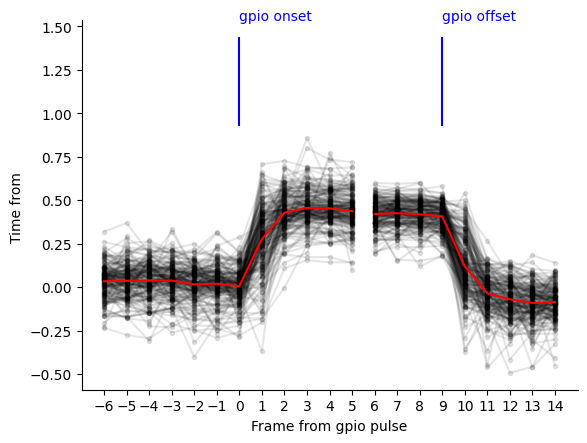

In [56]:
# trigger the camera frame average on the gpio pulses 
plt.figure()
ii = np.arange(len(avg))
aa = []
bb = []
idx = np.arange(-6,6)
idxpost = np.arange(-3,6)
for o,f in zip(ons[3],offs[3]):
    i = np.where(ii==o)[0][-1]
    pre = avg[:i].mean()
    aa.append(avg[i+idx]-pre)
    i = np.where(ii==f)[0][-1]
    
    bb.append(avg[i+idxpost]-pre)
plt.plot(idx,np.stack(aa).T,'.k-',alpha = 0.1);
plt.plot(idx,np.stack(aa).mean(axis = 0),'r-',alpha = 1);

plt.plot(idxpost+9,np.stack(bb).T,'.k-',alpha = 0.1);
plt.plot(idxpost+9,np.stack(bb).mean(axis = 0),'r-',alpha = 1);
plt.vlines([0,9],plt.ylim()[0]+2,plt.ylim()[-1],color = 'b')
plt.xticks(np.arange(idx[0],9+idxpost[-1]+1));
plt.text(0,plt.ylim()[-1], 'gpio onset',color = 'b')
plt.text(9,plt.ylim()[-1], 'gpio offset',color = 'b')
plt.ylabel('Frame brightness')
plt.ylabel('Time from ')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Frame from gpio pulse')
# plt.savefig('cam0_90Hz_sync_led.pdf')